In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite


<b>In the Previous iPython Notebook we have done the Exploratory Data Analysis, NLP - BOW, W2V, TF-IDF, Average W2V, Weighted W2V TF-IDF. In this notebook,we will do the Dimensiolaity Reduction techniques(PCA, T-SNE). </b>

## Loading the data

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from tqdm import tqdm

import re


In [3]:
con = sqlite3.connect('/kaggle/input/amazon-fine-food-reviews/database.sqlite') 
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000 """, con)
filtered_data["SentimentPolarity"] = filtered_data["Score"].apply(lambda x: 'Positive' if x>3 else 'Negative')
filtered_data["Class_Labels"] = filtered_data["SentimentPolarity"].apply(lambda x: 1 if x == 'Positive' else 0)

print("Number of Datapoints: ", filtered_data.shape)


Number of Datapoints:  (5000, 12)


In [4]:
display = pd.read_sql_query(""" SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*) FROM Reviews GROUP BY UserId HAVING COUNT(*) > 1 """, con)
print(display.head())

               UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B005ZBZLT4                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ESG  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B005ZBZLT4        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ESG           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBEV0   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2  


In [5]:
print(display["COUNT(*)"].sum())
print("There are {0} users who has bought the products more than once.".format(display.shape[0]) )

393063
There are 80668 users who has bought the products more than once.


# Exploratory Data Analysis

## Data Cleaning

In [6]:
#Sorting data according to ProductId in ascending order
sorted_data = filtered_data.sort_values("ProductId", axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [7]:
#Deduplication of entries

final = filtered_data.drop_duplicates(subset={"UserId", "ProfileName", "Time", "Text"}, keep='first', inplace=False)
print(final.shape)

(4986, 12)


In [8]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [10]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [11]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 12)


5    3412
4     766
1     502
2     306
Name: Score, dtype: int64

# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [12]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
This is not jerky, this is processed, hard like a rock, very greasy and stale smelling stripe of something that you can't break into anything smaller than 2 inches long and that certainly is not the size of a training treat! The dogs- 45lb dogs that will eat anything- were not impressed, it was hard to chew, and it sounded like they were crunching rocks, most of them spat it out after a few chews, left it there, this would be the first time they would not eat something in their entire lives, these dogs will work for lettuce. Where is a zero star button?
Aboulutely love Popchips!I first tried these healthy chips at a marathon i did in California. I like this variety pack because i got to try alot of the flavors ive never had.
M

In [13]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)


In [14]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
This is not jerky, this is processed, hard like a rock, very greasy and stale smelling stripe of something that you can't break into anything smaller than 2 inches long and that certainly is not the size of a training treat! The dogs- 45lb dogs that will eat anything- were not impressed, it was hard to chew, and it sounded like they were crunching rocks, most of them spat it out after a few chews, left it there, this would be the first time they would not eat something in their entire lives, these dogs will work for lettuce. Where is a zero star button?
Aboulutely love Popchips!I first tried these healthy chips at a marathon i did in California. I like this variety pack because i got to try alot of the flavors ive never had.
M

In [15]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [16]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Aboulutely love Popchips!I first tried these healthy chips at a marathon i did in California. I like this variety pack because i got to try alot of the flavors ive never had.


In [17]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.


In [18]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Aboulutely love Popchips I first tried these healthy chips at a marathon i did in California I like this variety pack because i got to try alot of the flavors ive never had 


In [19]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [20]:
# Combining all the above steps 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 4986/4986 [00:02<00:00, 2156.56it/s]


In [21]:
preprocessed_reviews[1500]

'aboulutely love popchips first tried healthy chips marathon california like variety pack got try alot flavors ive never'

In [22]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,SentimentPolarity,Class_Labels
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Negative,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Positive,1


In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|██████████| 4986/4986 [00:01<00:00, 3762.80it/s]


In [24]:
preprocessed_summary[100]

'delicious tea'

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split()) #list of arrays[['bought','several'],['vitality','canned']]

In [29]:
len(list_of_sentance)

4986

In [30]:
w2v_model=Word2Vec(list_of_sentance,min_count=5,vector_size=50, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))

[('anything', 0.9835715293884277), ('excellent', 0.9833479523658752), ('think', 0.981317937374115), ('overall', 0.9811079502105713), ('want', 0.9807285666465759), ('treat', 0.9800901412963867), ('either', 0.9798906445503235), ('still', 0.9798657894134521), ('decent', 0.9789931178092957), ('expected', 0.978959321975708)]
[('paste', 0.9980419278144836), ('lots', 0.9979525804519653), ('mixed', 0.9978850483894348), ('american', 0.997881293296814), ('varieties', 0.9976987242698669), ('potassium', 0.997689962387085), ('soup', 0.9976222515106201), ('clam', 0.9976138472557068), ('tomatoes', 0.9975493550300598), ('beef', 0.9974820017814636)]


In [31]:
w2v_words = list(w2v_model.wv.index_to_key)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['not', 'like', 'good', 'great', 'taste', 'one', 'product', 'would', 'flavor', 'love', 'coffee', 'food', 'chips', 'tea', 'no', 'really', 'get', 'best', 'much', 'amazon', 'use', 'time', 'buy', 'also', 'tried', 'little', 'find', 'make', 'price', 'better', 'bag', 'try', 'even', 'mix', 'well', 'chocolate', 'hot', 'eat', 'free', 'water', 'dog', 'first', 'made', 'could', 'found', 'used', 'bought', 'box', 'sugar', 'cup']


## [4.4.1] Converting text into vectors using wAvg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [32]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 4986/4986 [00:03<00:00, 1342.92it/s]

4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [33]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [34]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 4986/4986 [00:28<00:00, 176.25it/s]


In [35]:
tfidf_sent_vectors[0]

array([-0.00280295, -0.13089069,  0.16245879,  0.28211147, -0.29753409,
       -0.4786579 ,  0.27903425,  0.58207755, -0.64161761, -0.49311555,
        0.08529337, -0.25399357,  0.19625499,  0.20801417, -0.43235842,
        0.31229588,  0.67675842,  0.12596283, -0.68208809, -0.48801919,
        0.09241867,  0.29539465,  0.62787178, -0.21566597,  0.01575222,
        0.20314731, -0.23096164, -0.24147347, -0.42812682,  0.20264062,
        0.31860051,  0.17373295,  0.16130899, -0.019307  , -0.31923774,
        0.20994004,  0.23151014,  0.23246589,  0.14817454, -0.26821354,
        0.70931343, -0.09907487, -0.23579752, -0.00697179,  1.02627283,
        0.03754038,  0.00426411, -0.32434395,  0.58609581, -0.0325301 ])

## PCA
<b>PCA</b> is one of the famous dimensionlaity reduction technique. <b>PCA</b> tries find the direction of the unit vector where the variance of projected vectors is <b>Maximum</b>.

Lenght of pca_reduced records:  4986
Corresponding class labels are,  [1 0 1 ... 1 0 0]
[[-4.23696863 -2.64379027  1.        ]
 [-4.62725146  4.22843371  0.        ]
 [-2.99269582  4.52512573  1.        ]
 ...
 [-2.49612529 -2.27857178  1.        ]
 [ 2.09843935 -6.23913838  0.        ]
 [-4.38579293  2.58022648  0.        ]]


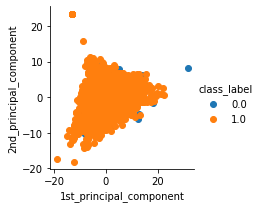

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
standardised_data = StandardScaler().fit_transform(tfidf_sent_vectors)

## PCA for visualisation
pca = PCA(n_components=2)
pca_reduced = pca.fit_transform(standardised_data)
print("Lenght of pca_reduced records: ",len(pca_reduced))
print("Corresponding class labels are, ",final["Class_Labels"].values)
# Appending the class labels to each of the components horizaontally row-wise
print(np.hstack((pca_reduced, np.array(final["Class_Labels"].values.reshape(len(final["Class_Labels"].values), 1)))))
pca_data = np.hstack((pca_reduced, np.array(final["Class_Labels"].values.reshape(len(final["Class_Labels"].values), 1))))
pca_df = pd.DataFrame(data=pca_data, columns=["1st_principal_component", "2nd_principal_component", "class_label"])
sns.FacetGrid(data = pca_df, hue="class_label").map(plt.scatter,'1st_principal_component', '2nd_principal_component').add_legend()
plt.show()

Cumulative Explained variance is:  [0.40102531 0.67662957 0.79799707 0.87035247 0.9202236  0.94543285
 0.9621136  0.97296005 0.97940577 0.98430115 0.98865206 0.99070888
 0.99202956 0.99313736 0.99411796 0.99492018 0.99557923 0.99618138
 0.9966076  0.99696532 0.99729599 0.99756526 0.99781385 0.99802703
 0.99822699 0.99839274 0.99854822 0.99869807 0.99882437 0.99894687
 0.99905684 0.99916345 0.99925614 0.99933773 0.99941096 0.99947792
 0.99954018 0.99959453 0.99964727 0.99969148 0.99973535 0.99977673
 0.99981365 0.99984657 0.99987846 0.99990701 0.99993488 0.99996049
 0.99998375 1.        ]


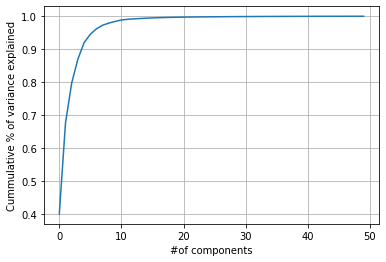

In [37]:
## PCA for dimensionality reduction.
pca = PCA()
pca.n_components=standardised_data.shape[1]
pca_reduced = pca.fit_transform(standardised_data)
percentage_var_explained = pca.explained_variance_/np.sum(pca.explained_variance_)
cum_var_explained = np.cumsum(percentage_var_explained)
print("Cumulative Explained variance is: ",cum_var_explained)
plt.plot(cum_var_explained)
plt.xlabel("#of components")
plt.ylabel("Cummulative % of variance explained")
plt.grid()
plt.show()

<b>Observation: </b>7 pricipal components are explaining 96% of the variance. Which means that out of 50 features we can consider these 7 components into consideration and make use for prediction as 96% variance is explained by this 7 components.

In [38]:
final["Class_Labels"].values

array([1, 0, 1, ..., 1, 0, 0])

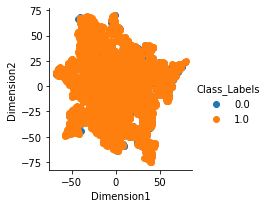

In [43]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
tsne_reduced = tsne.fit_transform(tfidf_sent_vectors)
tsne_data = np.hstack((tsne_reduced, np.array(final["Class_Labels"].values.reshape(len(final["Class_Labels"].values), 1))))
tsne_df = pd.DataFrame(data=tsne_data, columns=["Dimension1", "Dimension2", "Class_Labels"])
sns.FacetGrid(data = tsne_df, hue="Class_Labels").map(plt.scatter, "Dimension1", "Dimension2").add_legend()
plt.show()